# Instacart Market Basket Analysis

Instacart is a technology company providing a same day delivery grocery service to users across the U.S and Canada. Users place their grocery orders through the Instacart app and a personal Instacart shopper delivers the order to their home.

Instacart made public an anonymized data of 3 million Instacart shoppers presenting researchers with the challenge of predicting which previously purchased products will be in the user’s next order. 

This report presents an initial exploration data analysis of the dataset and describes how a subset of the data was selected for the analysis. 

Files:
orders.csv <br>
order_products__prior.csv <br>
order_products__train.csv <br>
products.csv <br>
aisles.csv <br>
departments.csv <br>



In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

In [65]:
# Reading csv files into Pandas DataFrames

filename_orders_file = 'files/orders.csv'
filename_products_prior = 'files/order_products__prior.csv'
filename_products_train= 'files/order_products__train.csv'
filename_products = 'files/products.csv'
filename_aisles = 'files/aisles.csv'
filename_departments = 'files/departments.csv'

orders = pd.read_csv(filename_orders_file)
order_products_prior = pd.read_csv(filename_products_prior)
order_products_train= pd.read_csv(filename_products_train)
products = pd.read_csv(filename_products) 
aisles = pd.read_csv(filename_aisles)
departments = pd.read_csv(filename_departments)

The 500th order was selected from the order_products_train.csv file and the matching order number from order_products_prior.csv was selected. 

The total number of orders in the subset is 3969 made by 255 user_id's. From those, 3714 are prior orders.

DataFrames:<br>
sample<br>
sample_orders_prior<br>
sample_orders_train<br>

In [67]:
#Forming subset of orders file. For this exercise, order_numbers that had both a prior and train data were selected.

# Orders with train eval_set are selected
orders_train = orders.loc[orders['eval_set'] == 'train']

# From the orders that had train data, every 400th row was selected to create a subset
sample_orders_train = orders_train[orders_train.index % 500 == 0]


# Prior orders are added to the sample
orders_sample = orders['user_id'].isin(sample_orders_train['user_id'])
sample = orders[orders_sample]
sample.describe()
print('The sample has', len(sample),'orders')
sample.head(2)

The sample has 3969 orders


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
14993,242494,940,prior,1,0,7,NaN
14994,1747069,940,prior,2,0,15,14.0


In [68]:
sample_orders_prior = sample.loc[sample['eval_set'] == 'prior']
print('The sample has', len(sample_orders_prior),'prior orders')


The sample has 3714 prior orders


In [69]:
user_id_unique = sample['user_id'].unique()
print('The sample has' , len(user_id_unique), 'unique users')

The sample has 255 unique users


In [70]:
orders_unique = sample_orders_prior['order_id'].unique()
print('In the sample, 255 users made' , len(orders_unique), 'number of prior orders')

orders_unique_total = sample['order_id'].unique()
print('And' , len(orders_unique_total), 'of total orders when including train orders')

In the sample, 255 users made 3714 number of prior orders
And 3969 of total orders when including train orders


In [71]:
print('In average each user placed', (len(user_id_unique)/len(orders_unique))*100, 'prior orders.')

print('In average each user placed', (len(user_id_unique)/len(orders_unique_total))*100, 'orders.')

In average each user placed 6.8659127625201934 prior orders.
In average each user placed 6.424792139077853 orders.


In average, each user in the subset placed 6.42 orders. The spread of the orders placed can be seen in the Maximum number of orders barplot showing that many users placed between 4 and 6 orders with a few placing as many as 100 orders.

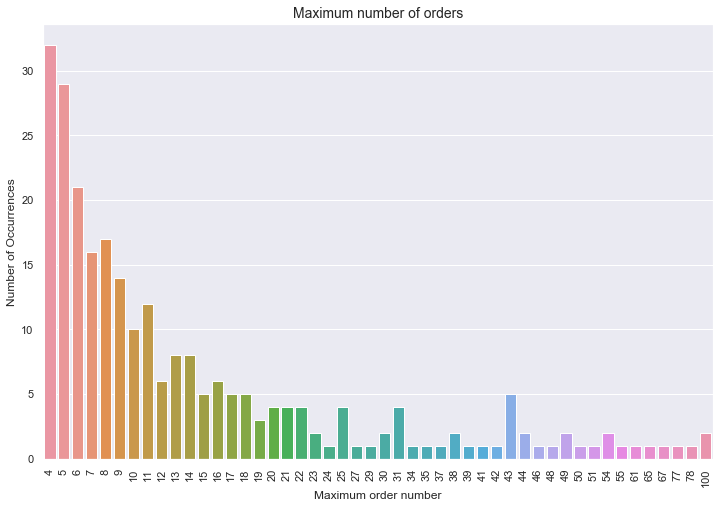

In [72]:
max_number = sample.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
max_number = max_number.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(max_number.index, max_number.values)
plt.title('Maximum number of orders', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The following section merges the DataFrames to create the product_merged_sample DataFrame with respective orders, products, departments, aisles, day of the week when the order was placed, time of the day, time since last order and whether it is a reordered product.

In [73]:
#Merging of order_products_prior with sub-sample. Creating orders_products_prior with 3714 prior orders and products 
#in each order.

orders_products_sample = order_products_prior['order_id'].isin(sample['order_id'])
orders_products_prior_sample = order_products_prior[orders_products_sample]
print(len(orders_products_prior_sample['order_id'].unique()))
orders_products_prior_sample.head()

3714


,order_id,product_id,add_to_cart_order,reordered
21206,2249,11365,1,1
21207,2249,43352,2,1
21208,2249,8571,3,1
23336,2451,2113,1,1
23337,2451,42585,2,1


In [75]:
#product_merged_sample contains prior orders with user_id, product_name, department, aisle and timeline.

merged_order_sample = pd.merge(orders_products_prior_sample, sample, on='order_id', how='left')
product_merged = pd.merge(merged_order_sample, products, on='product_id',how='left')
product_aisle_merged = pd.merge(product_merged, aisles[['aisle','aisle_id']], on = 'aisle_id', how = 'left')
product_department_merged = pd.merge(product_aisle_merged, departments[['department','department_id']], on = 'department_id', how = 'left')
product_merged_sample = product_department_merged[['user_id','order_id','order_number','product_id','product_name','aisle','department','eval_set','add_to_cart_order', 'order_dow', 'order_hour_of_day','days_since_prior_order', 'reordered']]


In [76]:
product_merged_sample.head(5)

,user_id,order_id,order_number,product_id,product_name,aisle,department,eval_set,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,102271,2249,9,11365,Leaf Spinach,packaged produce,produce,prior,1,3,21,15.0,1
1,102271,2249,9,43352,Raspberries,packaged produce,produce,prior,2,3,21,15.0,1
2,102271,2249,9,8571,Baby Cucumbers,packaged produce,produce,prior,3,3,21,15.0,1
3,159768,2451,33,2113,Ultra Comfort Care Mega Roll Toilet Paper,paper goods,household,prior,1,2,17,3.0,1
4,159768,2451,33,42585,Organic Extra Firm Tofu,tofu meat alternatives,deli,prior,2,2,17,3.0,1


## Which was the best seller?

The following plot shows a graphical representation of the top 10 products ordered by users. Organic fruits is the top category with organic bananas taking the first place among users.

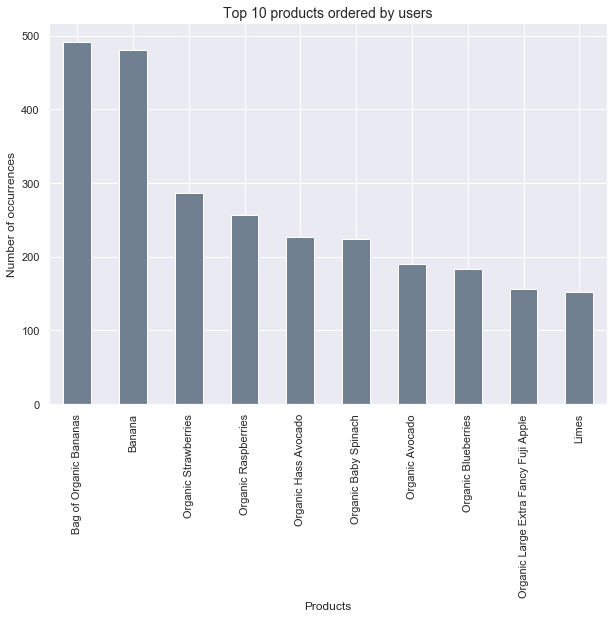

In [77]:
#Bar plot showing Number of Orders by Product 

plt.figure(figsize=(10,7))
ax = product_merged_sample['product_name'].value_counts()
ax.head(10).plot(kind='bar', color = 'slategrey')
plt.title('Top 10 products ordered by users', fontsize=14)
plt.xlabel('Products', fontsize=12)
plt.ylabel('Number of occurrences', fontsize=12)
plt.show() 

## Which products have a high reorder frequency?

To see the differences or similarities between the products that users are ordering and reordering, the top 10 reordered products are shown in the following plot.

The plot shows that users are consistent with their top organic fruits and vegetables choices and reorder them again. This time, organic whole milk makes the top 10 list.


In [79]:
#Creating a DataFrame of reordered products

reordered_products_prior = product_merged_sample.loc[product_merged_sample['reordered'] == 1]
print('The number of reordered products is', len(reordered_products_prior))


The number of reordered products is 21976


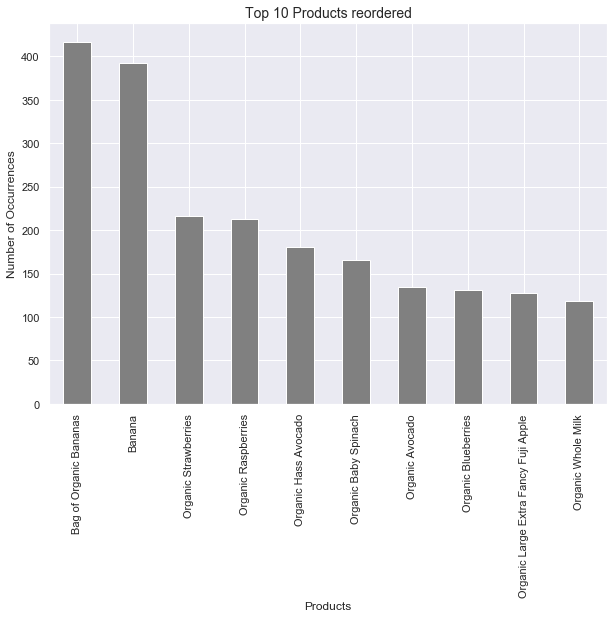

In [80]:
#Plot of top 10 reordered products

plt.figure(figsize=(10,7))
ax = reordered_products_prior['product_name'].value_counts()
ax.head(10).plot(kind='bar', color = 'gray')
plt.title('Top 10 Products reordered', fontsize=14)
plt.xlabel('Products', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show() 

# What is the reorder ratio of the products?



In [81]:
#Creating a DataFrame with frequency of orders
#Creating a column 'order_frequency'

cnt_top_purchased = product_merged_sample['product_name'].value_counts().reset_index().head(40)
cnt_top_purchased.columns = ['product_name', 'order_frequency']
cnt_top_purchased


#Creating a column 'reorder_frequency' 

cnt_reordered_products = reordered_products_prior['product_name'].value_counts().reset_index()
cnt_reordered_products.columns = ['product_name', 'reorder_frequency']
cnt_reordered_products

#Merging top purchased products DataFrame with count of reordered products DataFrame 

merged_cnt = pd.merge(cnt_top_purchased, cnt_reordered_products, on='product_name', how='left')


#Ratio of order to reordered products

merged_cnt['reorder_ratio'] = (merged_cnt['reorder_frequency'] / merged_cnt['order_frequency'])*100

rounded_merged_cnt=np.round(merged_cnt, decimals=2)

sorted_merged_cnt = rounded_merged_cnt.sort_values(by='reorder_ratio',ascending = False)

sorted_merged_cnt.head(10)




,product_name,order_frequency,reorder_frequency,reorder_ratio
16,2% Reduced Fat Milk,113,104,92.04
38,Fresh CA Grown Eggs,75,66,88.00
0,Bag of Organic Bananas,492,417,84.76
23,100% Whole Wheat Bread,93,78,83.87
29,Organic Large Brown Grade AA Cage Free Eggs,85,71,83.53
31,Sparkling Natural Mineral Water,83,69,83.13
3,Organic Raspberries,257,213,82.88
11,Organic Whole Milk,145,119,82.07
8,Organic Large Extra Fancy Fuji Apple,156,128,82.05
1,Banana,481,392,81.50


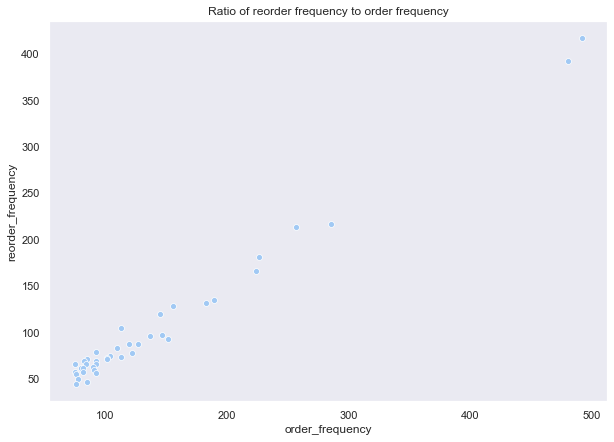

In [86]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=sorted_merged_cnt, x ='order_frequency', y='reorder_frequency' )
plt.title("Ratio of reorder frequency to order frequency")
plt.grid()
plt.show()

The scatterplot shows a strong correlation between ordered and reordered frequenccies. It shows how orders in the shopping cart might be repetitive. The barplot below shows the reorder ratio of selected items.

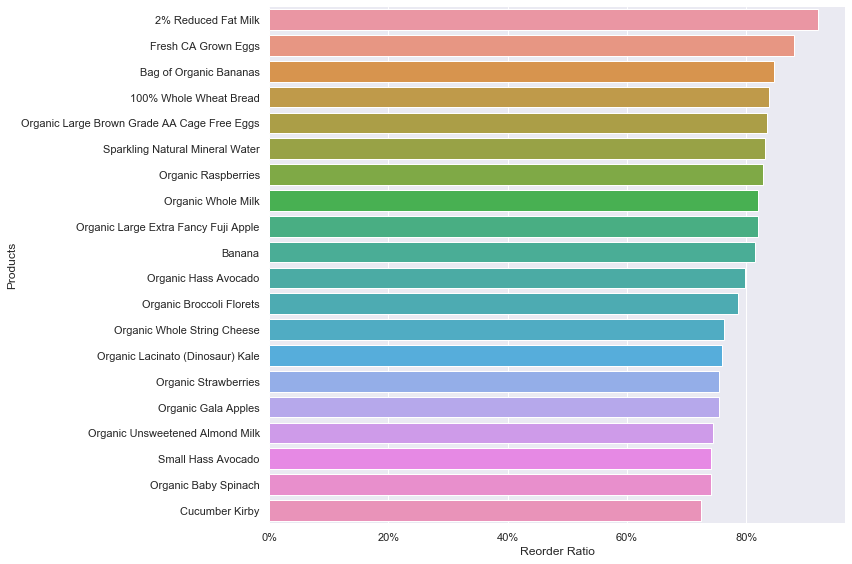

In [21]:
plt.figure(figsize=(12,8))

sns.set(style="darkgrid")
ax = sns.barplot(x="reorder_ratio", y="product_name", data=sorted_merged_cnt.head(20), label="Reorder Ratio")
sns.despine(left=True, bottom=True)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}%'.format(x) for x in vals])
plt.xlabel('Reorder Ratio')
plt.ylabel('Products')
plt.tight_layout()
plt.show()

# When do shoppers buy?

The barplot and countplot below show that shoppers buy mostly between 8am and 5pm. The countplot shows a steady increase that peaks at 3:00 p.m.  

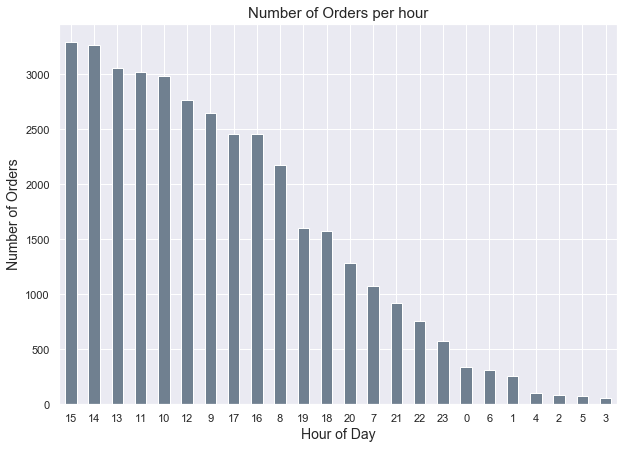

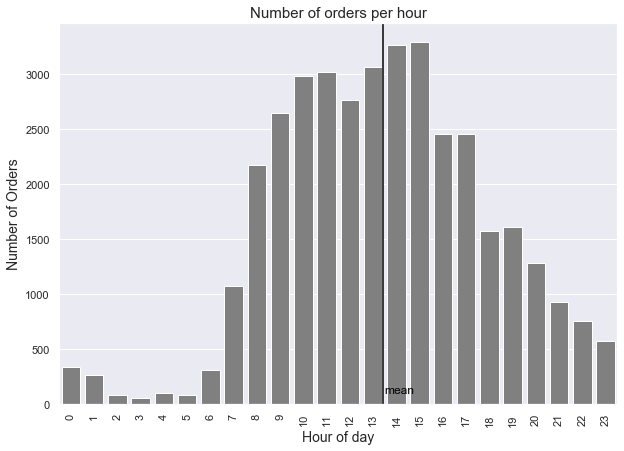

In [88]:
#Bar plot showing Number of Orders by time of day 

plt.figure(figsize=(10,7))
hour_of_day = product_merged_sample['order_hour_of_day'].value_counts()
hour_of_day.plot(kind = 'bar', rot=0, y='Number of Purchases', color = 'slategrey')
plt.title('Number of Orders per hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Orders',fontsize=14)
plt.show()

plt.figure(figsize=(10,7))
sns.countplot(x="order_hour_of_day", data=product_merged_sample, color = 'gray')
sns.set_palette("pastel")
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Hour of day', fontsize=14)
plt.xticks(rotation='vertical')
plt.axvline(np.mean(product_merged_sample['order_hour_of_day']), color='black')
plt.text(13.5,100,'mean', rotation=360, color='black')
plt.title("Number of orders per hour", fontsize=15)
plt.show()

# How many items in a shopping cart?

The minimum number of items in a shopping cart is 1 and the maximum number is 57.  75% percent of shoppers have 14 items of less in their shopping cart. The histogram below shows that the average is .

In [92]:
pd = product_merged_sample['order_id'].value_counts().reset_index()
pd.columns = ['order_id','items_in_shopping_cart']
pd.items_in_shopping_cart.describe()


count    3714.000000
mean        9.999731
std         7.245809
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max        57.000000
Name: items_in_shopping_cart, dtype: float64

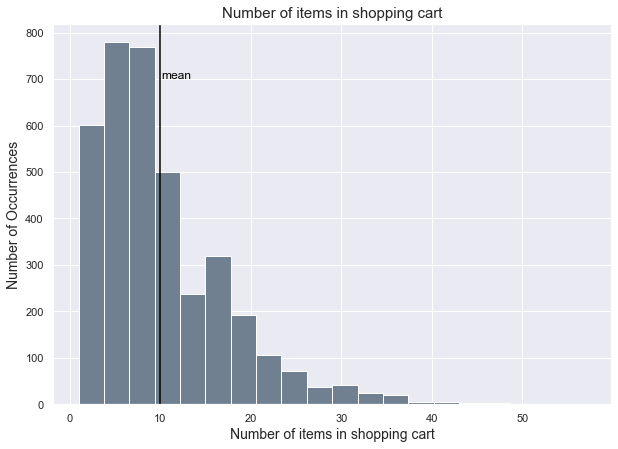

In [90]:
_ = plt.figure(figsize=(10,7))
_ = plt.hist(pd['items_in_shopping_cart'], bins=20, color = 'slategrey')
_ = plt.xlabel('Number of items in shopping cart', fontsize='14')
_ = plt.ylabel('Number of Occurrences', fontsize='14')
_ = plt.axvline(np.mean(pd.items_in_shopping_cart), color='black')
_ = plt.title('Number of items in shopping cart', fontsize='15')
_ = plt.text(10.1,700,'mean', rotation=360, color='black')
_ = plt.show()

# Conclusion

So far, this exercise has shown that shoppers use the Instacart app to buy many of their produce, dairy and bakery items.  Organic produce is a top category.  There seems to be consistency when reordering items and there is a strong correlation between orders and reorders, specially among the products of higher order frequencies.

After initial exploration, we will continue to analyze:<br>

- How shopping cart item order affects reordering
- How time between orders affect reordering
